In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import linkage, dendrogram
# from kneebow.rotor import Rotor
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import seaborn as sns
import numpy as np
import os
import re
from energy_consumption_architecture.utils.paths import data_dir

## Funciones auxiliares

In [2]:
#We calculate or k-distance for determinate our eps value.
def calculate_kn_distance(X, neigh=2):
    neigh = NearestNeighbors(n_neighbors=neigh)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    return distances[:,1:].reshape(-1)

#We get the eps exact value using kneebow, this function allows
#us to find the elbow of a curve by rotating the curve and taking
#the minimum value.
def get_eps(X, neigh=2):
    eps_dist = np.sort(calculate_kn_distance(X, neigh=neigh))
    rotor = Rotor()
    curve_xy = np.concatenate([np.arange(eps_dist.shape[0]).reshape(-1, 1), eps_dist.reshape(-1, 1)],1)
    rotor.fit_rotate(curve_xy)
    rotor.plot_elbow()
    e_idx = rotor.get_elbow_index()
    return curve_xy[e_idx]

## carga de datos 

In [3]:
file_path=data_dir("interim","estadisticas_edificios.csv")

In [4]:
data = pd.read_csv(file_path)
data.head()

,type_building,var1_mean,var1_std_dev,var2_mean,var2_std_dev
0,RefBldgFullServiceRestaurantNew2004,0.000000,6.226848,19.4245,7.265027
1,RefBldgFullServiceRestaurantNew2004,0.001580,6.596764,19.4245,7.265027
2,RefBldgFullServiceRestaurantNew2004,0.002568,7.146033,19.4245,7.265027
3,RefBldgFullServiceRestaurantNew2004,0.000000,4.688730,19.4245,7.265027
4,RefBldgFullServiceRestaurantNew2004,0.000000,4.797245,19.4245,7.265027


In [5]:
data.columns

Index(['type_building', 'var1_mean', 'var1_std_dev', 'var2_mean',
       'var2_std_dev'],
      dtype='object')

In [6]:
# Obtener un resumen estadístico y mostrar la información general del conjunto de datos
summary = data.describe()
summary

,var1_mean,var1_std_dev,var2_mean,var2_std_dev
count,80.000000,80.000000,80.000000,80.000000
mean,41.707922,46.497957,44.721192,24.728418
std,120.139988,72.987056,61.317985,31.327799
min,0.000000,1.201939,1.011600,1.278151
25%,0.000000,6.376172,11.303727,4.654335
50%,0.000000,10.853409,22.338642,13.133033
75%,7.759010,36.654344,44.437106,27.107491
max,511.932392,264.972046,199.362908,116.539481


In [7]:
info = data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   type_building  80 non-null     object 
 1   var1_mean      80 non-null     float64
 2   var1_std_dev   80 non-null     float64
 3   var2_mean      80 non-null     float64
 4   var2_std_dev   80 non-null     float64
dtypes: float64(4), object(1)
memory usage: 3.3+ KB


In [8]:
# Identificar valores faltantes
missing_values = data.isnull().sum()
missing_values

type_building    0
var1_mean        0
var1_std_dev     0
var2_mean        0
var2_std_dev     0
dtype: int64

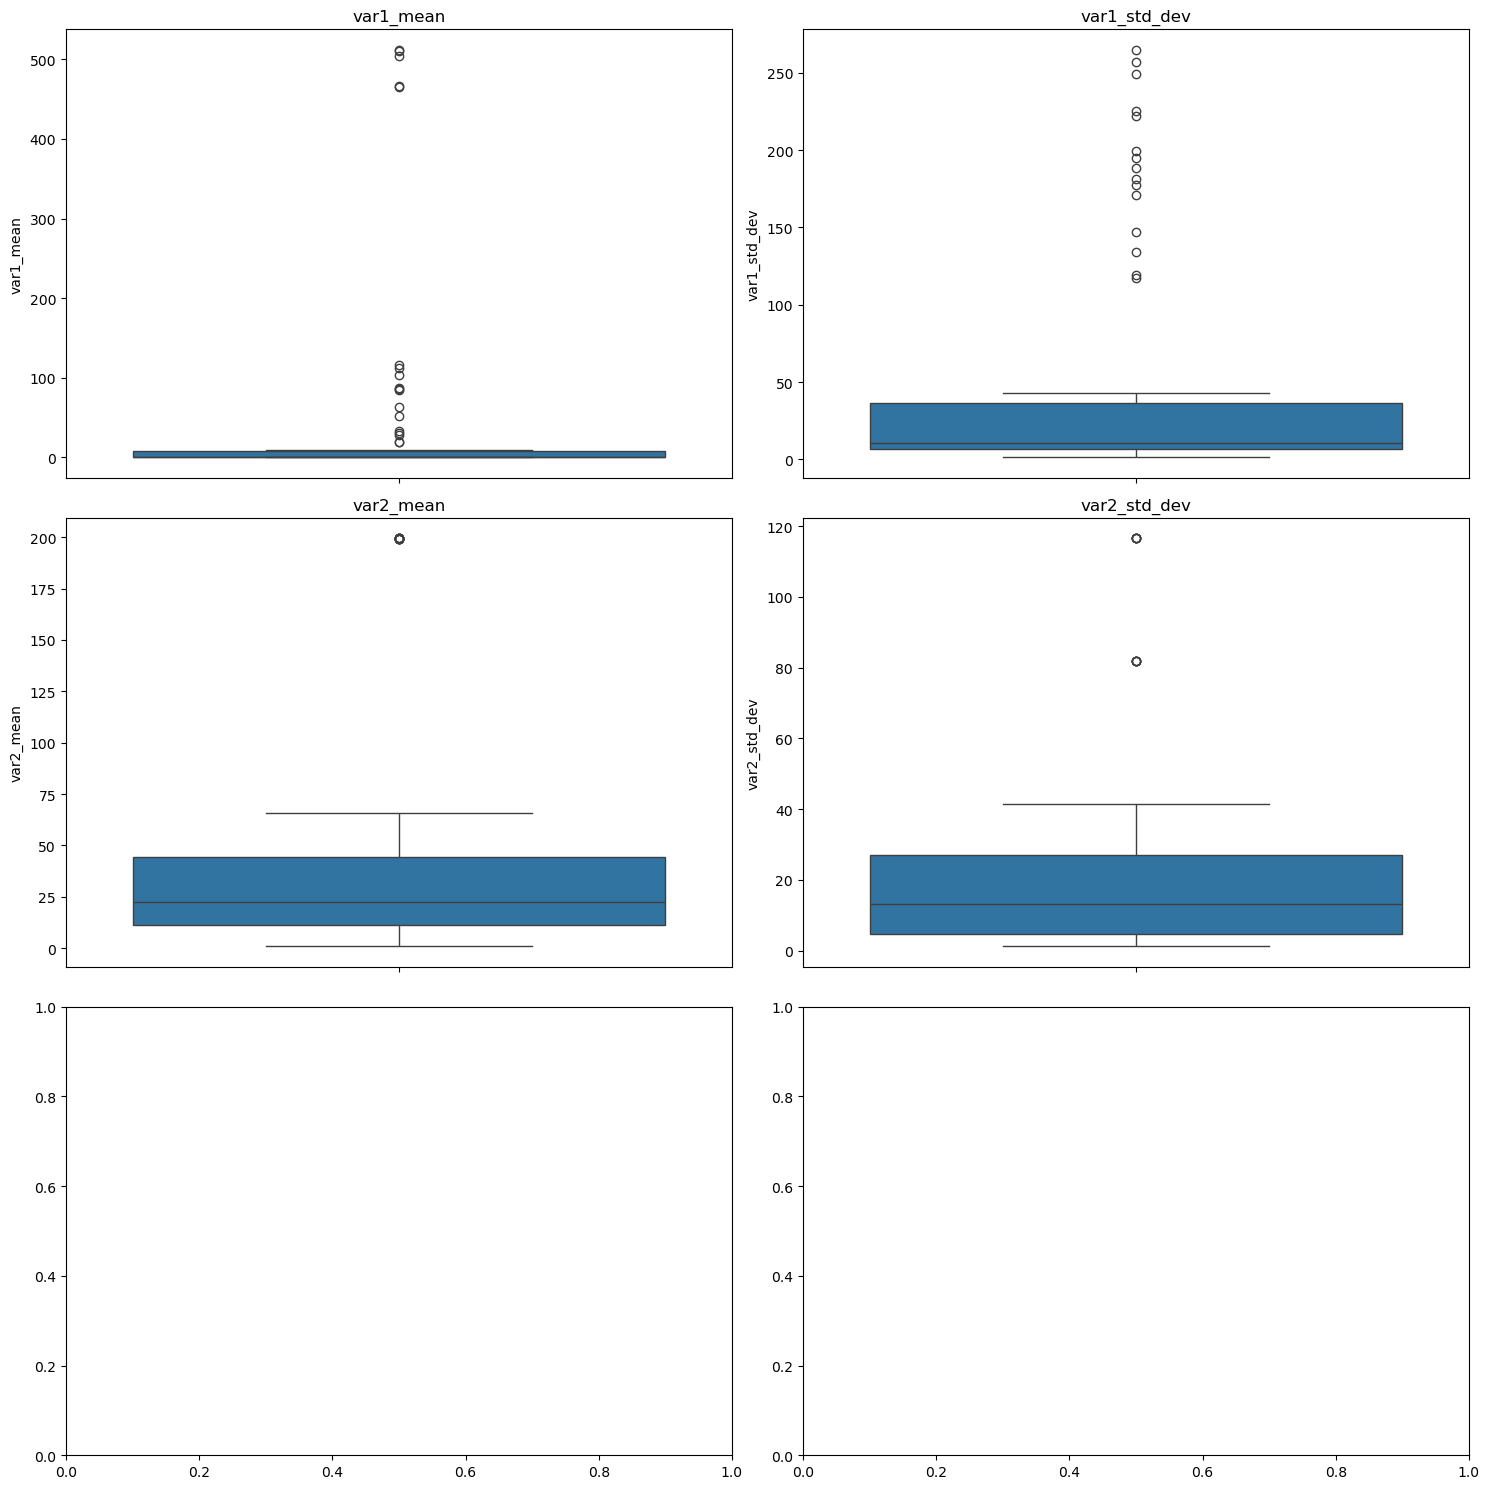

In [9]:
int_cols = data.select_dtypes(exclude='object').columns
num_plots = len(int_cols)
rows = 3  # Número de filas deseadas
cols = num_plots // rows + (num_plots % rows > 0)  # Número de columnas deseadas

fig, axes = plt.subplots(rows, cols, figsize=(15, 15))  # Ajusta el tamaño de la figura según tus necesidades

for i, col in enumerate(int_cols):
    ax = axes[i // cols, i % cols] if rows > 1 else axes[i % cols]  # Obtén el eje correspondiente
    sns.boxplot(data=data, y=col, ax=ax)
    ax.set_title(col)  # Opcional: establece el título de cada gráfico

plt.tight_layout()  # Ajusta el espaciado entre los gráficos
plt.show()

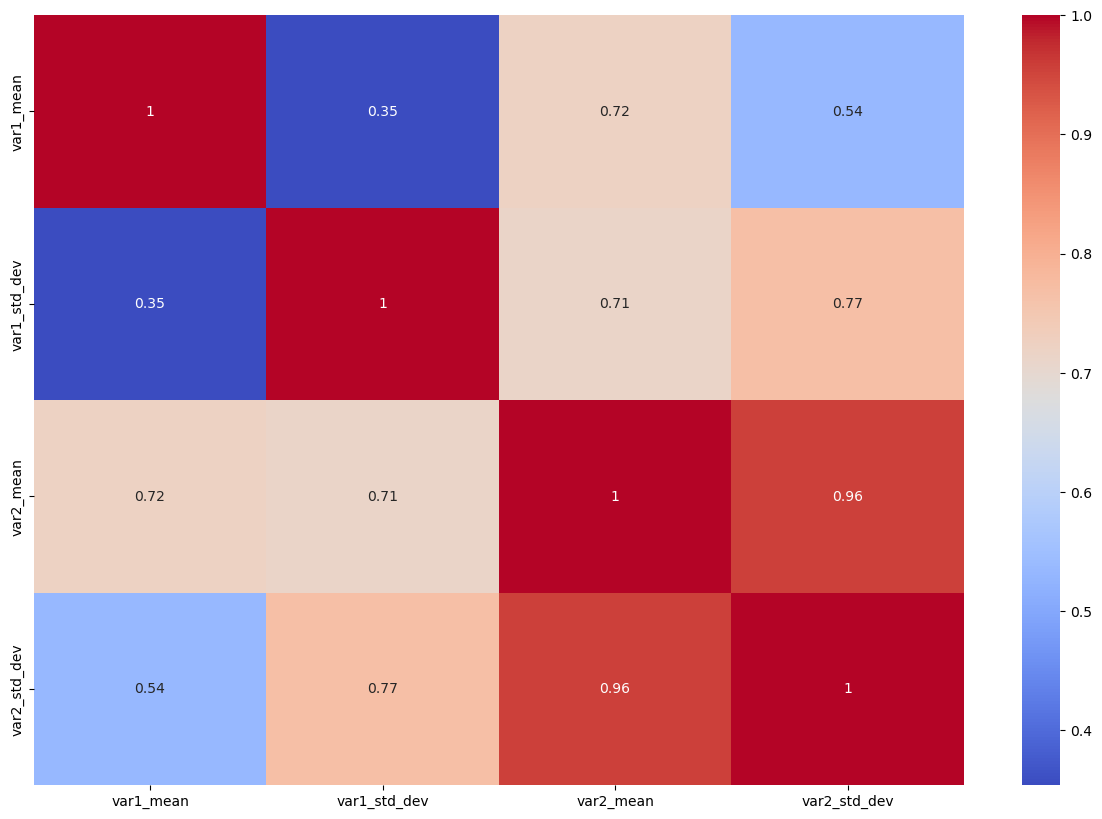

In [10]:
fig = plt.figure(figsize=(15,10))
sns.heatmap(data.iloc[:,1:].corr(), annot=True, cmap='coolwarm')
plt.show()

In [11]:
# Seleccionar todas las columnas numéricas para la estandarización
numeric_columns = data.select_dtypes(include=['float64']).columns

# Estandarizar los datos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[numeric_columns])

# Convertir de nuevo a un DataFrame para mantener la consistencia
data_scaled_df = pd.DataFrame(data_scaled, columns=numeric_columns)
# Añadir la columna 'type_building' de nuevo
data_scaled_df['type_building'] = data['type_building']

# Mostrar los primeros registros del DataFrame estandarizado
data_scaled_df.head()


,var1_mean,var1_std_dev,var2_mean,var2_std_dev,type_building
0,-0.349351,-0.555238,-0.415152,-0.560958,RefBldgFullServiceRestaurantNew2004
1,-0.349338,-0.550138,-0.415152,-0.560958,RefBldgFullServiceRestaurantNew2004
2,-0.349330,-0.542565,-0.415152,-0.560958,RefBldgFullServiceRestaurantNew2004
3,-0.349351,-0.576445,-0.415152,-0.560958,RefBldgFullServiceRestaurantNew2004
4,-0.349351,-0.574949,-0.415152,-0.560958,RefBldgFullServiceRestaurantNew2004


In [12]:
# Separar las características numéricas
features = data_scaled_df.drop(columns=['type_building']).copy()

In [13]:
features.head()

,var1_mean,var1_std_dev,var2_mean,var2_std_dev
0,-0.349351,-0.555238,-0.415152,-0.560958
1,-0.349338,-0.550138,-0.415152,-0.560958
2,-0.349330,-0.542565,-0.415152,-0.560958
3,-0.349351,-0.576445,-0.415152,-0.560958
4,-0.349351,-0.574949,-0.415152,-0.560958


In [14]:
features.iloc[:, :6]

,var1_mean,var1_std_dev,var2_mean,var2_std_dev
0,-0.349351,-0.555238,-0.415152,-0.560958
1,-0.349338,-0.550138,-0.415152,-0.560958
2,-0.349330,-0.542565,-0.415152,-0.560958
3,-0.349351,-0.576445,-0.415152,-0.560958
4,-0.349351,-0.574949,-0.415152,-0.560958
...,...,...,...,...
75,-0.349351,-0.592238,-0.717332,-0.684502
76,-0.349351,-0.588995,-0.717332,-0.684502
77,-0.349351,-0.586375,-0.717332,-0.684502
78,-0.349351,-0.606257,-0.717332,-0.684502


## CLUSTERING 

In [15]:
data_clustered=data.copy()
X=features.copy()

### KMEANS

In [16]:
# Método del Codo para K-means
Sum_of_squared_distances = []
silhouette_scores = []
K_range = range(2, 11)
for _ in K_range:
    km = KMeans(n_clusters = _)
    y = km.fit_predict(X)
    Sum_of_squared_distances.append(km.inertia_)
    silhouette_scores.append(silhouette_score(X,y))

C:\Users\ASUS TUF\.conda\envs\energy_consumption_architecture\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\energy_consumption_architecture\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\energy_consumption_architecture\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ASUS TUF\.conda\

C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_52344\2047102112.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bx-" (-> marker='x'). The keyword argument will take precedence.
  ax[0].plot(K_range, Sum_of_squared_distances, 'bx-', marker='o')
C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_52344\2047102112.py:12: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "rx-" (-> marker='x'). The keyword argument will take precedence.
  ax[1].plot(K_range, silhouette_scores, 'rx-', marker='o')


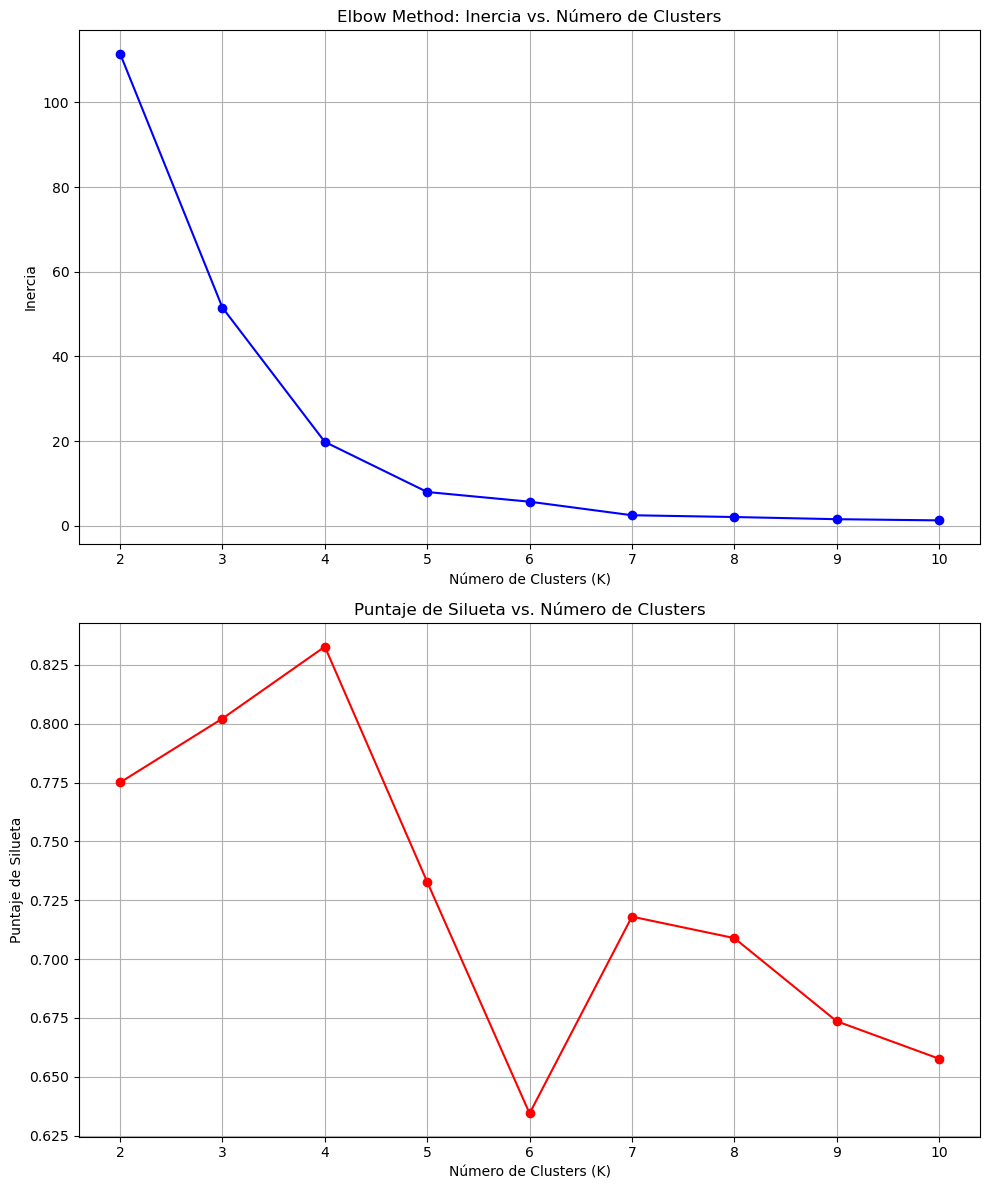

In [17]:
# Configurar las figuras y los subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 12))

# Gráfico de la suma de distancias cuadradas
ax[0].plot(K_range, Sum_of_squared_distances, 'bx-', marker='o')
ax[0].set_xlabel('Número de Clusters (K)')
ax[0].set_ylabel('Inercia')
ax[0].set_title('Elbow Method: Inercia vs. Número de Clusters')
ax[0].grid(True)

# Gráfico del puntaje de silueta
ax[1].plot(K_range, silhouette_scores, 'rx-', marker='o')
ax[1].set_xlabel('Número de Clusters (K)')
ax[1].set_ylabel('Puntaje de Silueta')
ax[1].set_title('Puntaje de Silueta vs. Número de Clusters')
ax[1].grid(True)

# Mostrar las gráficas
plt.tight_layout()
plt.show()

In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def determinar_numero_optimo_clusters(X, K_range=range(2, 11)):
    Sum_of_squared_distances = []
    silhouette_scores = []
    
    # Ajustar el modelo KMeans para cada valor en el rango de K
    for k in K_range:
        km = KMeans(n_clusters=k, random_state=42)
        y = km.fit_predict(X)
        Sum_of_squared_distances.append(km.inertia_)
        silhouette_scores.append(silhouette_score(X, y))
    
    # Calcular las tasas de cambio relativas en la inercia (diferencias proporcionales)
    inertia_ratios = [(i - j) / i for i, j in zip(Sum_of_squared_distances[:-1], Sum_of_squared_distances[1:])]
    
    # Identificar el codo (donde la tasa de cambio relativa es mayor)
    max_inertia_ratio_index = inertia_ratios.index(max(inertia_ratios)) + 3  # Cambiado a +3 para seleccionar K después del cambio
    
    # Encontrar el valor de K con la mayor puntuación de silhouette
    max_silhouette_index = silhouette_scores.index(max(silhouette_scores)) + 2
    
    print(f"El codo ocurre en K={max_inertia_ratio_index}")
    print(f"El valor óptimo según silhouette es K={max_silhouette_index}")
    
    # Devolver el número óptimo de clusters
    if max_inertia_ratio_index == max_silhouette_index:
        return max_inertia_ratio_index
    else:
        print("Hay una discrepancia entre el método del codo y silhouette. Considera ambos resultados.")
        return max_inertia_ratio_index, max_silhouette_index

# Ejemplo de uso
numero_optimo = determinar_numero_optimo_clusters(X)


El codo ocurre en K=4
El valor óptimo según silhouette es K=4


C:\Users\ASUS TUF\.conda\envs\energy_consumption_architecture\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\energy_consumption_architecture\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ASUS TUF\.conda\envs\energy_consumption_architecture\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\ASUS TUF\.conda\

In [54]:
# Calcular las diferencias entre inercias
inertia_differences = [j - i for i, j in zip(Sum_of_squared_distances[:-1], Sum_of_squared_distances[1:])]
# Imprimir las diferencias entre inercias
for i, diff in enumerate(inertia_differences, start=2):
    print(f"Diferencia de inercia entre {i-1} y {i} clusters: {diff}")

Diferencia de inercia entre 1 y 2 clusters: -40.110368741371815
Diferencia de inercia entre 2 y 3 clusters: -51.61520150701307
Diferencia de inercia entre 3 y 4 clusters: -11.835451318907861
Diferencia de inercia entre 4 y 5 clusters: -2.2890199682069454
Diferencia de inercia entre 5 y 6 clusters: -3.2008794386387875
Diferencia de inercia entre 6 y 7 clusters: -0.3354165851029731
Diferencia de inercia entre 7 y 8 clusters: -0.5972785099338769
Diferencia de inercia entre 8 y 9 clusters: -0.4471165087358864


basandonos en la grafica de los cambios de inercia  utilizamos el metodo del codo para determinar el numero optimo de clusters a agrupar estan entre 2 a 3

In [21]:
# Aplicar K-means con un número de clusters razonable, por ejemplo, 3
kmeans = KMeans(n_clusters=4, random_state=42)
clusters_kmeans = kmeans.fit_predict(X)

# Agregar los clusters al DataFrame para análisis posterior
data_clustered['Cluster_KMeans'] = clusters_kmeans
# Mostrar los primeros registros con los clusters asignados
data_clustered.head()

,type_building,var1_mean,var1_std_dev,var2_mean,var2_std_dev,Cluster_KMeans
0,RefBldgFullServiceRestaurantNew2004,0.000000,6.226848,19.4245,7.265027,0
1,RefBldgFullServiceRestaurantNew2004,0.001580,6.596764,19.4245,7.265027,0
2,RefBldgFullServiceRestaurantNew2004,0.002568,7.146033,19.4245,7.265027,0
3,RefBldgFullServiceRestaurantNew2004,0.000000,4.688730,19.4245,7.265027,0
4,RefBldgFullServiceRestaurantNew2004,0.000000,4.797245,19.4245,7.265027,0


**Silueta**
El coeficiente de silueta mide cuán similares son los objetos dentro de un mismo cluster comparados con objetos de otros clusters. Va de -1 a 1, donde valores cercanos a 1 indican buenos clusters, cercanos a 0 indican clusters solapados y valores negativos indican asignaciones incorrectas.

In [22]:
# Calcular el silhouette score para evaluar la calidad de los clusters
silhouette_kmeans = silhouette_score(X, clusters_kmeans)
silhouette_kmeans

0.8327310944025669

**Índice de Davies-Bouldin**
Mide la compactación de los clusters y la separación entre ellos. Un valor más bajo indica una mejor formación de clusters.

In [23]:
# Calcular el índice de Davies-Bouldin
davies_bouldin = davies_bouldin_score(X, clusters_kmeans)
davies_bouldin

0.1719481278478642

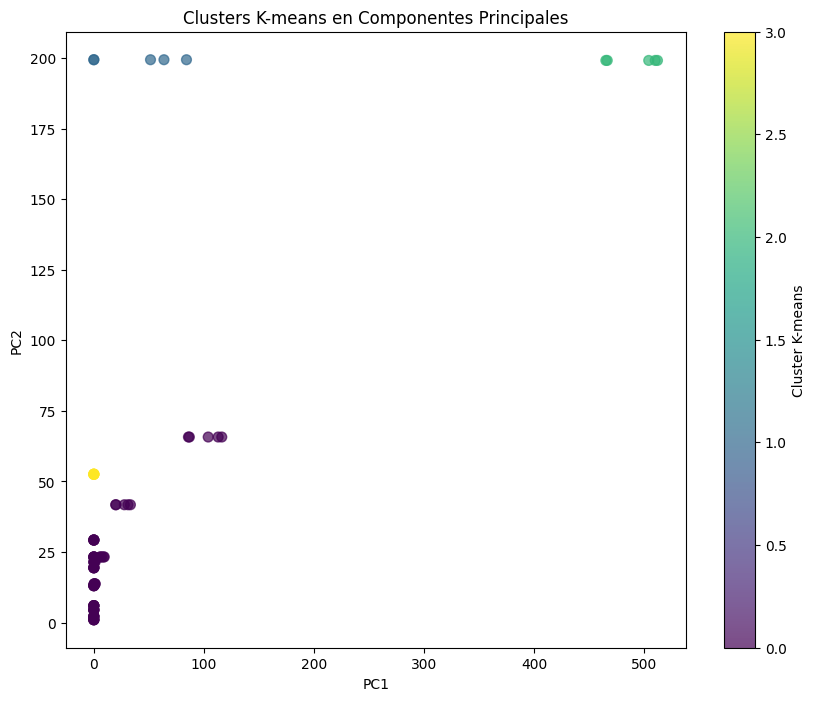

In [24]:
# Visualización de los clusters obtenidos por K-means
plt.figure(figsize=(10, 8))
plt.scatter(data_clustered['var1_mean'], data_clustered['var2_mean'], c=data_clustered['Cluster_KMeans'], cmap='viridis', s=50, alpha=0.7)
plt.title('Clusters K-means en Componentes Principales')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster K-means')
# # Assign the cluster centers: centroids
# centroids = kmeans.cluster_centers_

# # Assign the columns of centroids: centroids_x, centroids_y
# centroids_x = centroids[:,0]
# centroids_y = centroids[:,1]

# # Make a scatter plot of centroids_x and centroids_y
# """
# scatter plot of centroids_x and centroids_y, using 'D' (a diamond) as a marker by specifying the marker parameter. Set the size of the markers to be 50 using s=50.
# """
# plt.scatter(centroids_x,centroids_y,marker="D",s=50)
plt.show()

In [25]:
# Create crosstab: ct
ct = pd.crosstab(data_clustered['type_building'] ,data_clustered['Cluster_KMeans'] )
# Display ct
ct

Cluster_KMeans,0,1,2,3
type_building,,,,
RefBldgFullServiceRestaurantNew2004,5,0,0,0
RefBldgHospitalNew2004,0,0,5,0
RefBldgLargeHotelNew2004,5,0,0,0
RefBldgLargeOfficeNew2004,0,5,0,0
RefBldgMediumOfficeNew2004,5,0,0,0
RefBldgMidriseApartmentNew2004,5,0,0,0
RefBldgOutPatientNew2004,5,0,0,0
RefBldgPrimarySchoolNew2004,5,0,0,0
RefBldgQuickServiceRestaurantNew2004,5,0,0,0


In [29]:
data_clustered.head()

,type_building,var1_mean,var1_std_dev,var2_mean,var2_std_dev,Cluster_KMeans
0,RefBldgFullServiceRestaurantNew2004,0.000000,6.226848,19.4245,7.265027,0
1,RefBldgFullServiceRestaurantNew2004,0.001580,6.596764,19.4245,7.265027,0
2,RefBldgFullServiceRestaurantNew2004,0.002568,7.146033,19.4245,7.265027,0
3,RefBldgFullServiceRestaurantNew2004,0.000000,4.688730,19.4245,7.265027,0
4,RefBldgFullServiceRestaurantNew2004,0.000000,4.797245,19.4245,7.265027,0


In [31]:
data_scaled_df = data_clustered.rename(columns={
    'var1_mean': 'Electricity:Facility_mean',
    'var1_std_dev': 'Electricity:Facility_std',
    'var2_mean': 'Cooling:Electricity_mean',
    'var2_std_dev': 'Cooling:Electricit_std',
    'var3_mean': 'InteriorEquipment:Electricity_mean',
    'var3_std_dev': 'InteriorEquipment:Electricity_std'
})
print(data_scaled_df.columns)
# Lista de las nuevas columnas
features = data_scaled_df[['Electricity:Facility_mean', 'Electricity:Facility_std', 
                           'Cooling:Electricity_mean', 'Cooling:Electricit_std', 
                           'InteriorEquipment:Electricity_mean', 'InteriorEquipment:Electricity_std']]

# Plotear los boxplots
for var in features.columns:
    plt.figure(figsize=(14, 10))
    sns.boxplot(data=data_scaled_df, x='Cluster_KMeans', y=var)
    plt.title(f'Distribución de {var} por Cluster')
    plt.show()

Index(['type_building', 'Electricity:Facility_mean',
       'Electricity:Facility_std', 'Cooling:Electricity_mean',
       'Cooling:Electricit_std', 'Cluster_KMeans'],
      dtype='object')


KeyError: "['InteriorEquipment:Electricity_mean', 'InteriorEquipment:Electricity_std'] not in index"

## DBSCAN

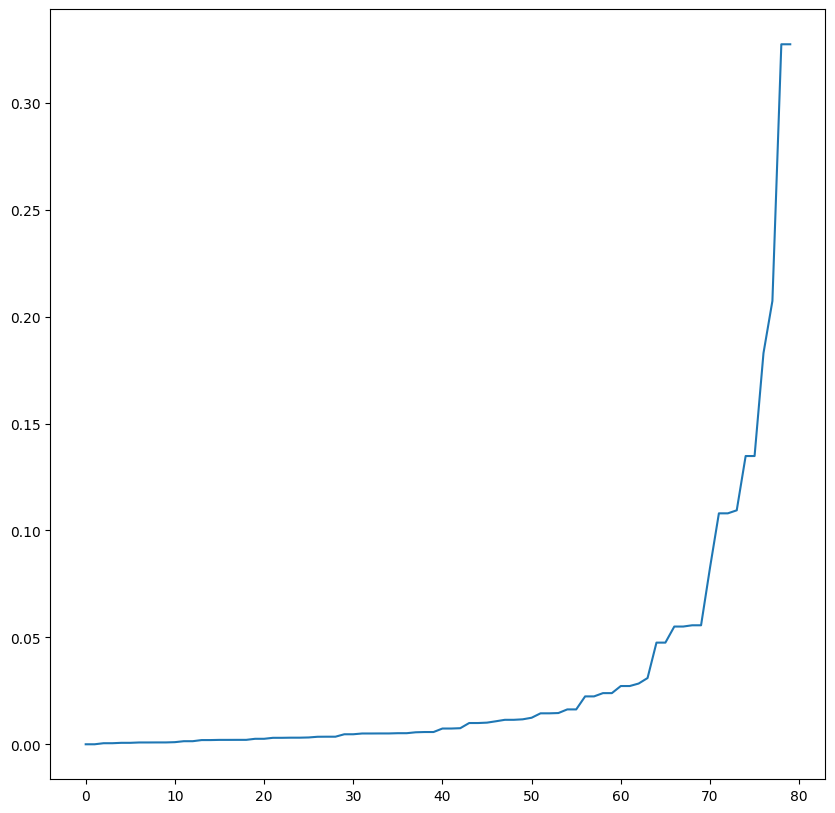

In [32]:
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(features)
distances, indices = neighbors_fit.kneighbors(features)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
fig = plt.figure(figsize=(10,10))
plt.plot(distances)

In [49]:
eps_values = np.arange(0.05, 0.20, 0.05)
min_samples = np.arange(3,12)

In [50]:
from itertools import product 
dbscan_paramns = list(product(eps_values,min_samples))
no_of_clusters = []
sil_score = []
for p in dbscan_paramns:
    y_dbscan = DBSCAN(eps=p[0], min_samples=p[1]).fit_predict(X)
    try:
        sil_score.append(silhouette_score(X,y_dbscan))
    except:
        sil_score.append(0)    
    no_of_clusters.append(len(np.unique(y_dbscan)))

In [51]:
df_param_tunning = pd.DataFrame.from_records(dbscan_paramns, columns=['Eps','Min_samples'])
df_param_tunning['sil_score'] = sil_score
df_param_tunning['n_clusters'] = no_of_clusters

In [52]:
pivot_1 = pd.pivot_table(df_param_tunning, values='sil_score', columns='Eps', index='Min_samples')
pivot_2 = pd.pivot_table(df_param_tunning, values='n_clusters', columns='Eps', index='Min_samples')

In [53]:
pivot_1.head()

Eps,0.05,0.10,0.15,0.20
Min_samples,,,,
3,0.470328,0.541732,0.566802,0.637811
4,0.373605,0.489127,0.519902,0.620888
5,0.373605,0.489127,0.445710,0.620888
6,-0.166577,0.139945,0.342517,0.601817
7,-0.166577,0.139945,0.342517,0.601817


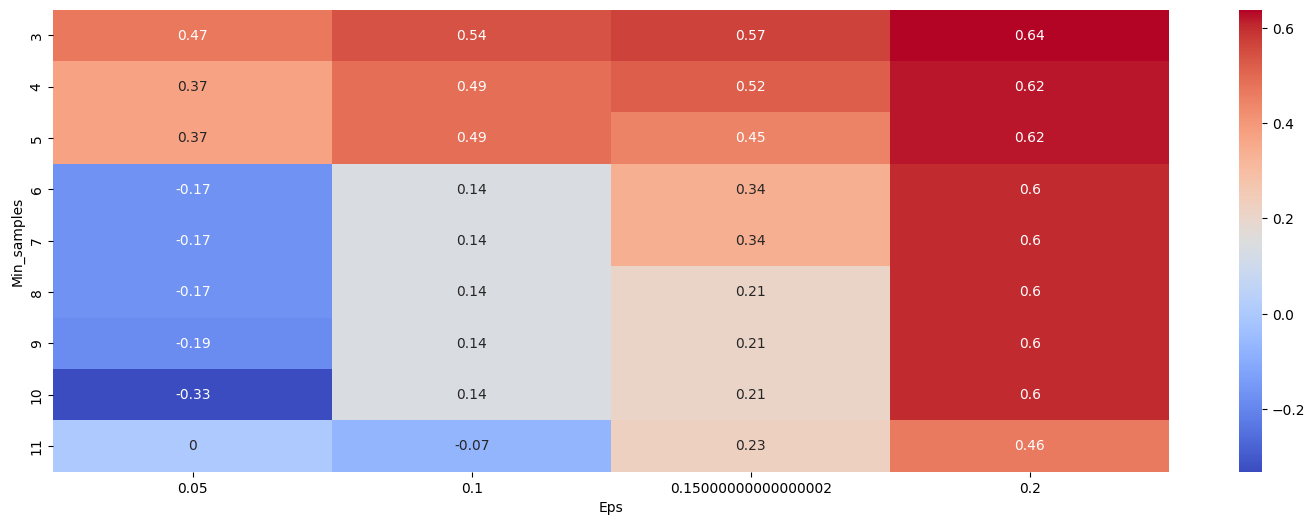

In [54]:
fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={'size':10}, cmap='coolwarm', ax=ax)
plt.show()

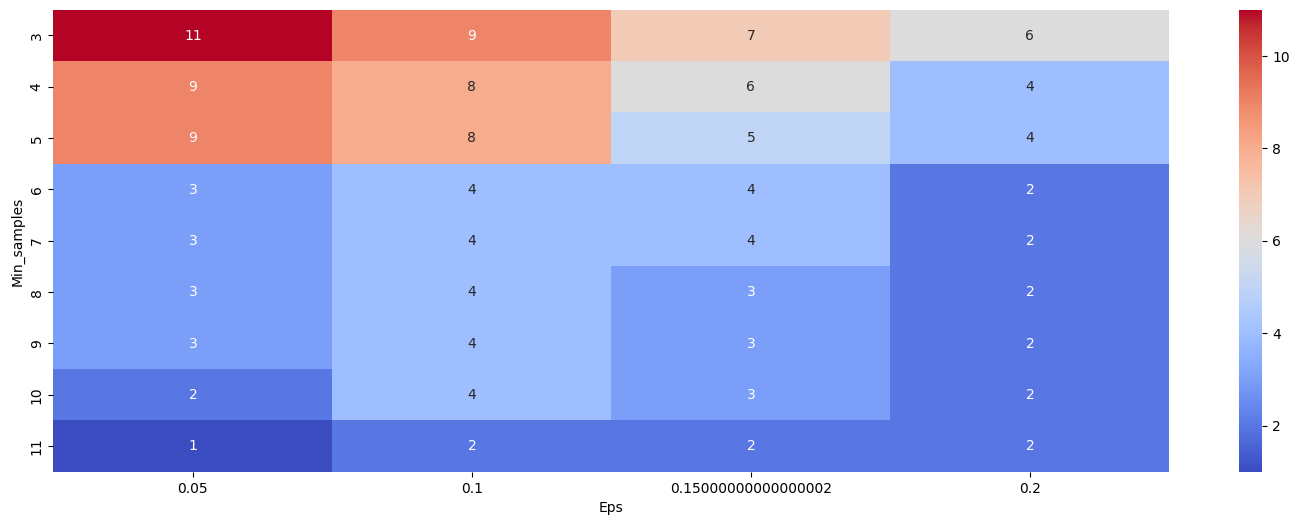

In [55]:
fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_2, annot=True, annot_kws={'size':10}, cmap='coolwarm', ax=ax)
plt.show()

In [61]:
# Aplicar DBSCAN
dbscan = DBSCAN(eps=0.2, min_samples=5)
clusters_dbscan = dbscan.fit_predict(X)

# Agregar los clusters al DataFrame para análisis posterior
data_clustered['Cluster_DBSCAN'] = clusters_dbscan
# Mostrar los primeros registros con los clusters asignados por DBSCAN
data_clustered.head()

,type_building,var1_mean,var1_std_dev,var2_mean,var2_std_dev,Cluster_KMeans,Cluster_DBSCAN
0,RefBldgFullServiceRestaurantNew2004,0.000000,6.226848,19.4245,7.265027,0,0
1,RefBldgFullServiceRestaurantNew2004,0.001580,6.596764,19.4245,7.265027,0,0
2,RefBldgFullServiceRestaurantNew2004,0.002568,7.146033,19.4245,7.265027,0,0
3,RefBldgFullServiceRestaurantNew2004,0.000000,4.688730,19.4245,7.265027,0,0
4,RefBldgFullServiceRestaurantNew2004,0.000000,4.797245,19.4245,7.265027,0,0


**Silueta**
El coeficiente de silueta mide cuán similares son los objetos dentro de un mismo cluster comparados con objetos de otros clusters. Va de -1 a 1, donde valores cercanos a 1 indican buenos clusters, cercanos a 0 indican clusters solapados y valores negativos indican asignaciones incorrectas.

In [62]:
# Calcular el silhouette score para evaluar la calidad de los clusters, excluyendo los puntos ruidosos
if len(set(clusters_dbscan)) > 1:
    silhouette_dbscan = silhouette_score(features, clusters_dbscan)
else:
    silhouette_dbscan = -1  # Silhouette score no es aplicable si hay un solo cluster
silhouette_dbscan

0.6208876191306375

**Índice de Davies-Bouldin**
Mide la compactación de los clusters y la separación entre ellos. Un valor más bajo indica una mejor formación de clusters.

In [63]:
# Calcular el índice de Davies-Bouldin
davies_bouldin_dbscan= davies_bouldin_score(features, clusters_dbscan)
davies_bouldin_dbscan

0.7538996739519968

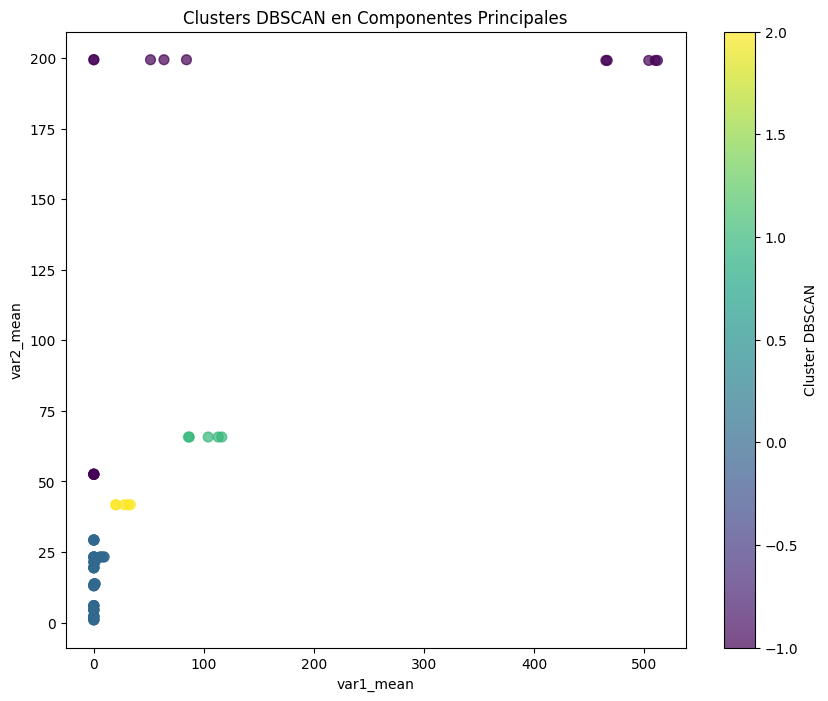

In [64]:
# Visualización de los clusters obtenidos por DBSCAN
plt.figure(figsize=(10, 8))
plt.scatter(data_clustered['var1_mean'], data_clustered['var2_mean'], c=data_clustered['Cluster_DBSCAN'], cmap='viridis', s=50, alpha=0.7)
plt.title('Clusters DBSCAN en Componentes Principales')
plt.xlabel('var1_mean')
plt.ylabel('var2_mean')
plt.colorbar(label='Cluster DBSCAN')
plt.show()

In [65]:
# Create crosstab: ct
ct = pd.crosstab(data_clustered['type_building'] ,data_clustered['Cluster_DBSCAN'] )
# Display ct
ct

Cluster_DBSCAN,-1,0,1,2
type_building,,,,
RefBldgFullServiceRestaurantNew2004,0,5,0,0
RefBldgHospitalNew2004,5,0,0,0
RefBldgLargeHotelNew2004,0,0,5,0
RefBldgLargeOfficeNew2004,5,0,0,0
RefBldgMediumOfficeNew2004,0,5,0,0
RefBldgMidriseApartmentNew2004,0,5,0,0
RefBldgOutPatientNew2004,0,0,0,5
RefBldgPrimarySchoolNew2004,0,5,0,0
RefBldgQuickServiceRestaurantNew2004,0,5,0,0


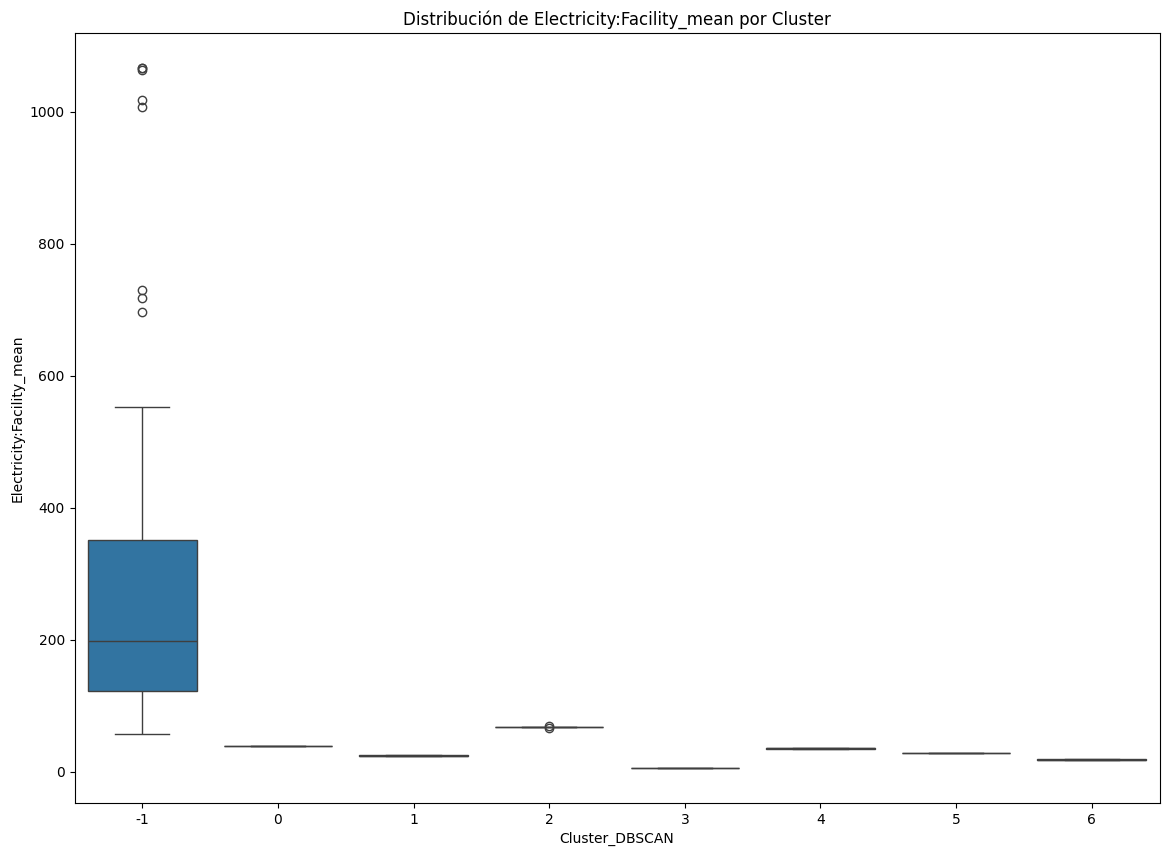

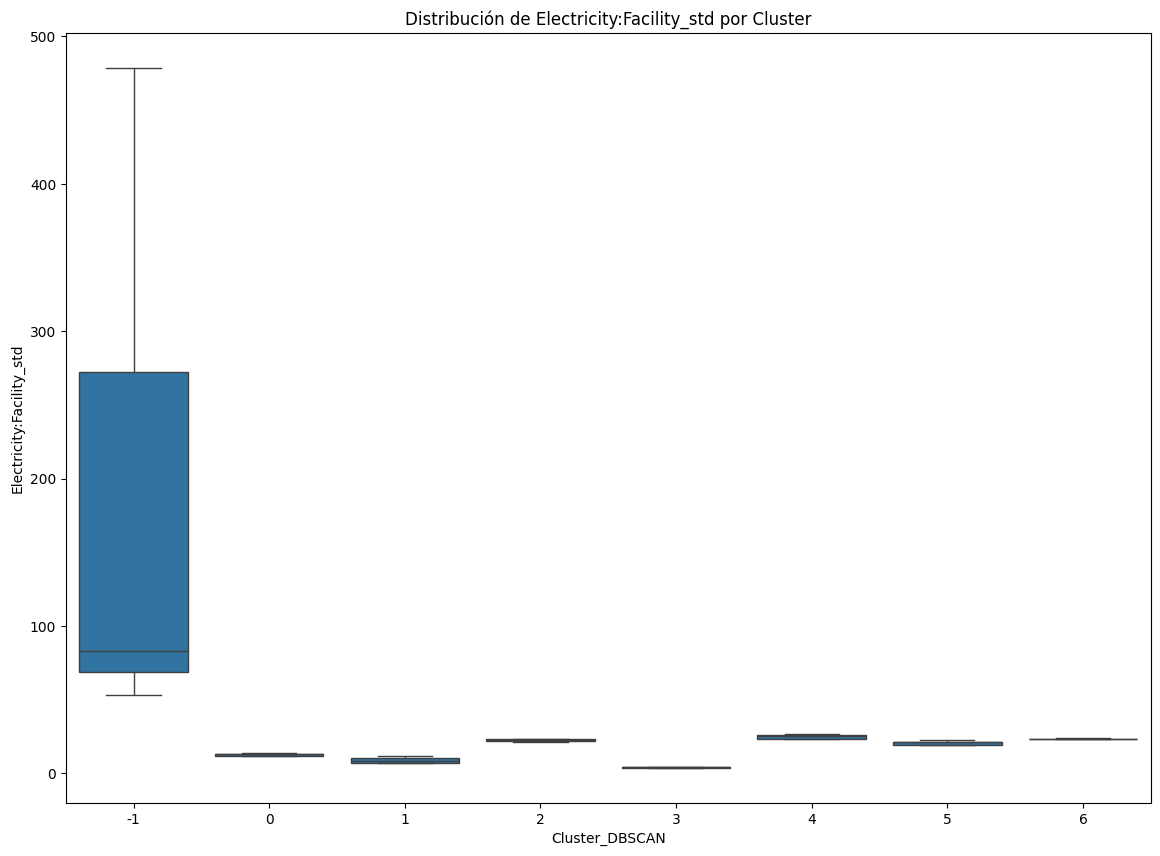

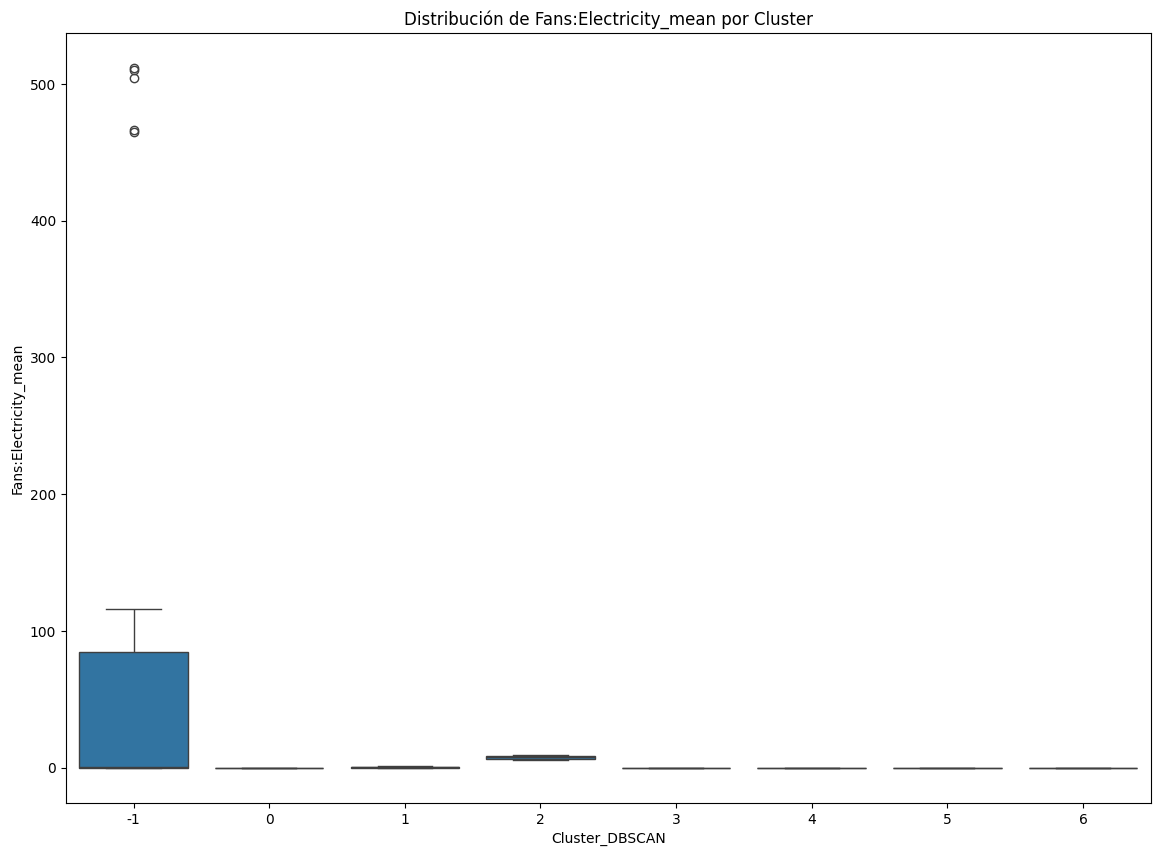

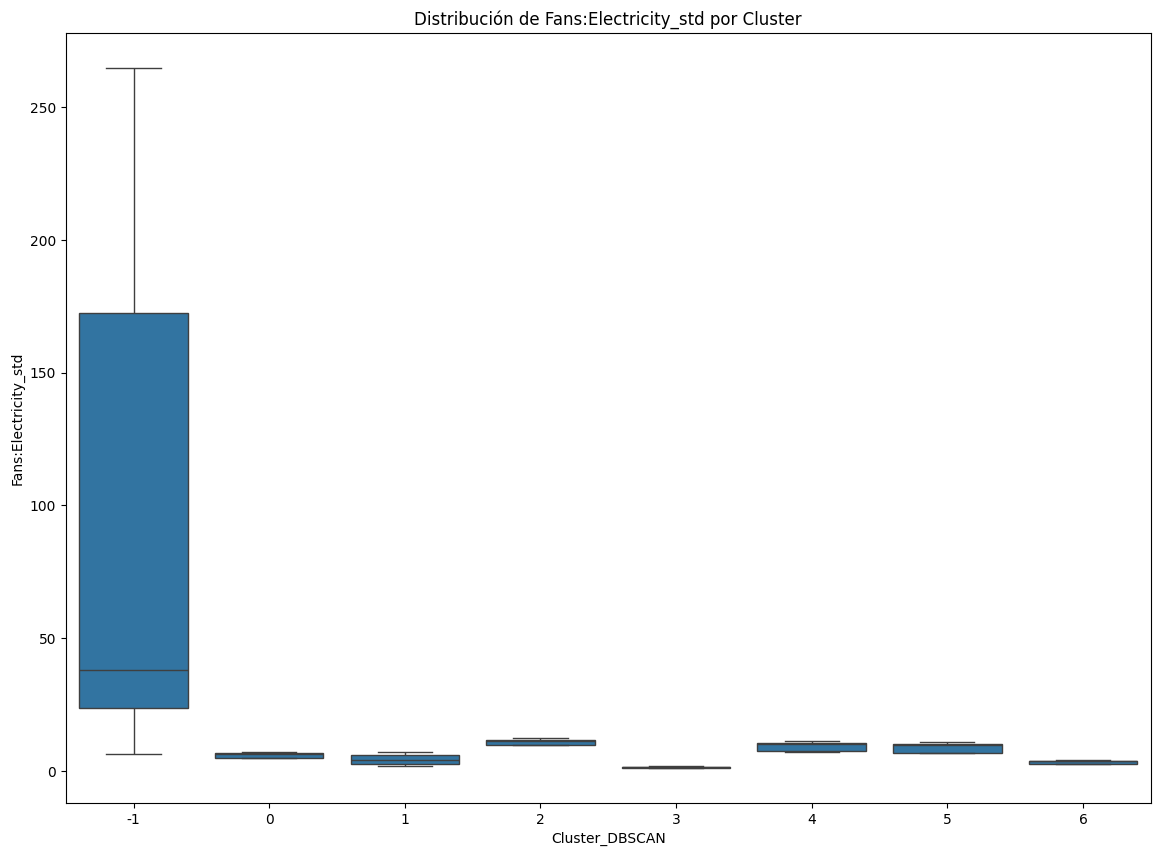

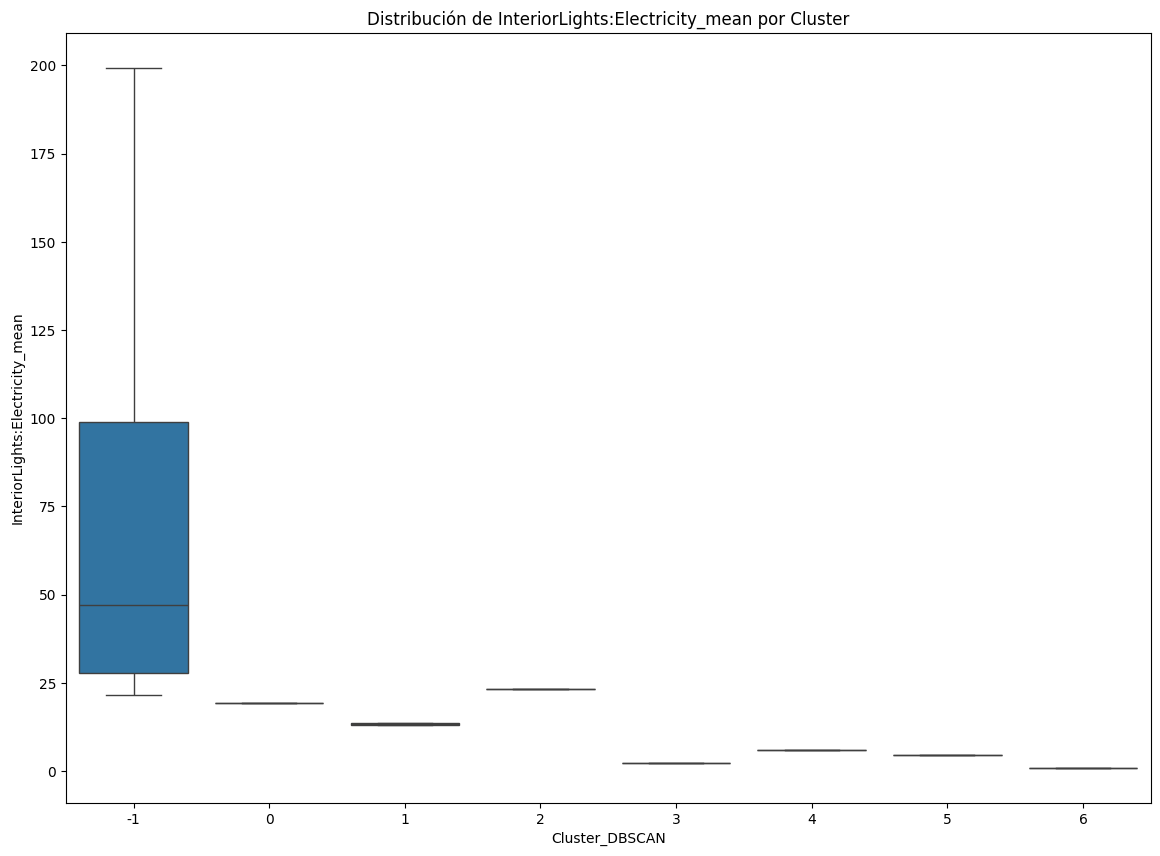

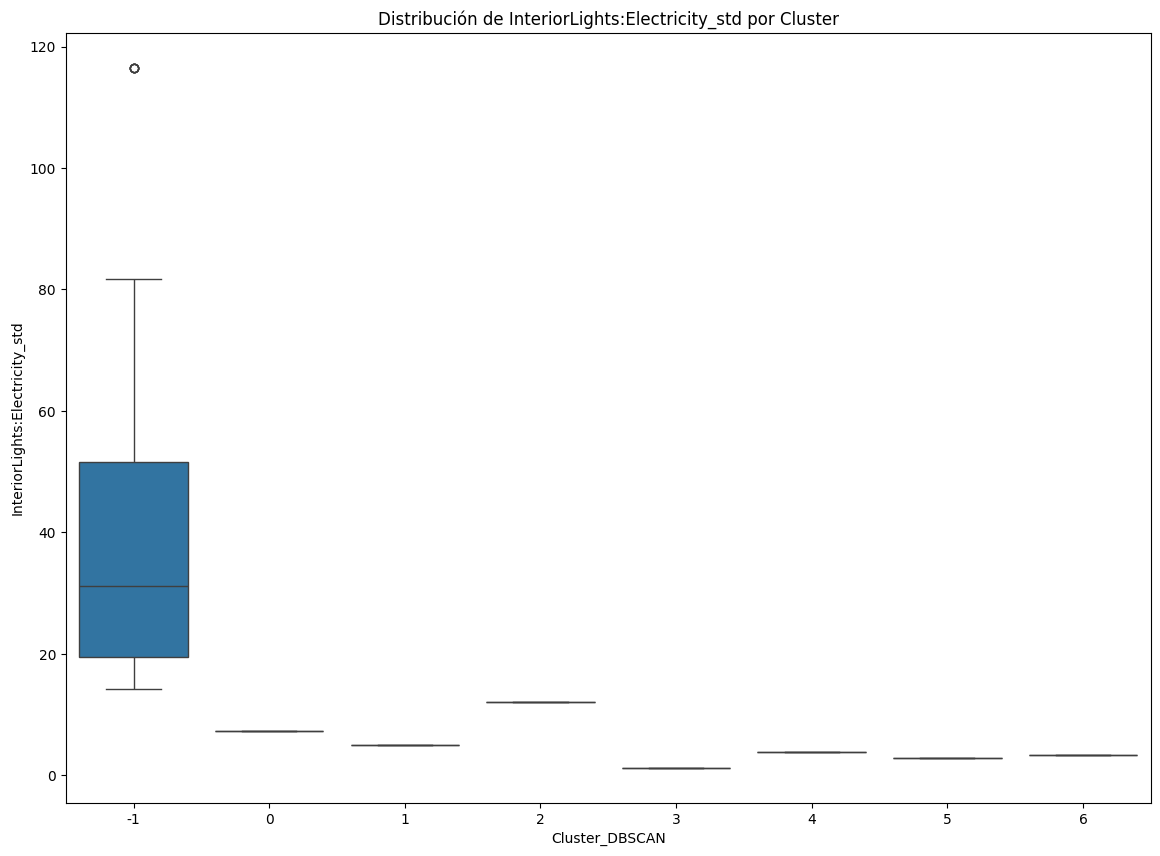

In [104]:
data_scaled_df = data_clustered.rename(columns={
    'var1_mean': 'Electricity:Facility_mean',
    'var1_std_dev': 'Electricity:Facility_std',
    'var2_mean': 'Fans:Electricity_mean',
    'var2_std_dev': 'Fans:Electricity_std',
    'var3_mean': 'InteriorLights:Electricity_mean',
    'var3_std_dev': 'InteriorLights:Electricity_std'
})

# Lista de las nuevas columnas
features_df = data_scaled_df[['Electricity:Facility_mean', 'Electricity:Facility_std', 
                           'Fans:Electricity_mean', 'Fans:Electricity_std', 
                           'InteriorLights:Electricity_mean', 'InteriorLights:Electricity_std']]

# Plotear los boxplots
for var in features_df.columns:
    plt.figure(figsize=(14, 10))
    sns.boxplot(data=data_scaled_df, x='Cluster_DBSCAN', y=var)
    plt.title(f'Distribución de {var} por Cluster')
    plt.show()

## CLUSTERING HERARQUICO 

In [21]:
from scipy.cluster.hierarchy import linkage
import numpy as np

def optimal_clusters_hierarchical(features, method='ward', last_n=10):
    """
    Calcula el número óptimo de clusters para clustering jerárquico usando la aceleración en la linkage matrix.

    Parámetros:
    - features: Matriz de características para clustering.
    - method: Método de linkage. Por defecto es 'ward'.
    - last_n: Número de fusiones a considerar para calcular el número óptimo de clusters. Por defecto es 10.

    Retorna:
    - Número óptimo de clusters.
    """

    # Calcular la linkage matrix
    mergings = linkage(features, method=method)

    # Obtener las alturas de los últimos 'last_n' clusters
    last = mergings[-last_n:, 2]
    last_rev = last[::-1]

    # Calcular la aceleración (segunda derivada)
    acceleration = np.diff(last, 2)  # Segunda derivada de las alturas
    acceleration_rev = acceleration[::-1]

    # Encontrar el número óptimo de clusters
    optimal_k = acceleration_rev.argmax() + 2  # +2 porque se pierde una posición en cada derivada

    return optimal_k


In [24]:
optimal_k=optimal_clusters_hierarchical(X, method='ward', last_n=10)

In [25]:
# Aplicar Clustering Jerárquico
hierarchical = AgglomerativeClustering(n_clusters=optimal_k)
clusters_hierarchical = hierarchical.fit_predict(X)

# Agregar los clusters al DataFrame para análisis posterior
data_clustered['Cluster_Hierarchical'] = clusters_hierarchical
# Mostrar los primeros registros con los clusters asignados por Clustering Jerárquico
data_clustered.head()

,type_building,var1_mean,var1_std_dev,var2_mean,var2_std_dev,Cluster_Hierarchical
0,RefBldgFullServiceRestaurantNew2004,0.000000,6.226848,19.4245,7.265027,1
1,RefBldgFullServiceRestaurantNew2004,0.001580,6.596764,19.4245,7.265027,1
2,RefBldgFullServiceRestaurantNew2004,0.002568,7.146033,19.4245,7.265027,1
3,RefBldgFullServiceRestaurantNew2004,0.000000,4.688730,19.4245,7.265027,1
4,RefBldgFullServiceRestaurantNew2004,0.000000,4.797245,19.4245,7.265027,1


**Silueta**
El coeficiente de silueta mide cuán similares son los objetos dentro de un mismo cluster comparados con objetos de otros clusters. Va de -1 a 1, donde valores cercanos a 1 indican buenos clusters, cercanos a 0 indican clusters solapados y valores negativos indican asignaciones incorrectas.

In [65]:
# Calcular el silhouette score para evaluar la calidad de los clusters
silhouette_hierarchical = silhouette_score(features, clusters_hierarchical)
silhouette_hierarchical

np.float64(0.7626587728848943)

**Índice de Davies-Bouldin**
Mide la compactación de los clusters y la separación entre ellos. Un valor más bajo indica una mejor formación de clusters.

In [66]:
# Calcular el índice de Davies-Bouldin
davies_bouldin_hierarchical= davies_bouldin_score(features, clusters_hierarchical)
davies_bouldin_hierarchical

np.float64(0.6994511315438892)

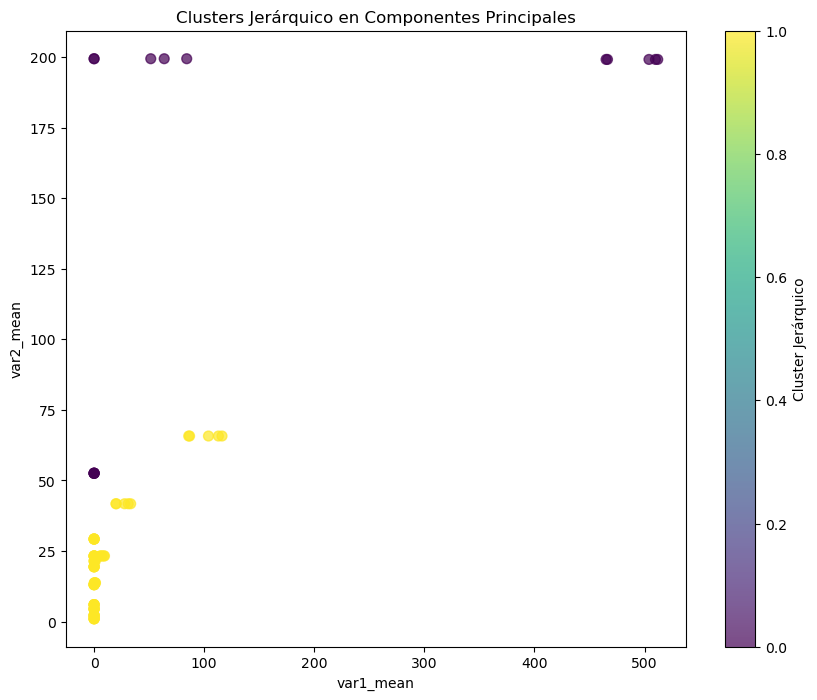

In [67]:
# Visualización de los clusters obtenidos por Clustering Jerárquico
plt.figure(figsize=(10, 8))
plt.scatter(data_clustered["var1_mean"], data_clustered['var2_mean'], c=data_clustered['Cluster_Hierarchical'], cmap='viridis', s=50, alpha=0.7)
plt.title('Clusters Jerárquico en Componentes Principales')
plt.xlabel('var1_mean')
plt.ylabel('var2_mean')
plt.colorbar(label='Cluster Jerárquico')
plt.show()

In [68]:
# Create crosstab: ct
ct = pd.crosstab(data_clustered['type_building'] ,data_clustered['Cluster_Hierarchical'] )
# Display ct
ct

Cluster_Hierarchical,0,1
type_building,,
RefBldgFullServiceRestaurantNew2004,0,5
RefBldgHospitalNew2004,5,0
RefBldgLargeHotelNew2004,0,5
RefBldgLargeOfficeNew2004,5,0
RefBldgMediumOfficeNew2004,0,5
RefBldgMidriseApartmentNew2004,0,5
RefBldgOutPatientNew2004,0,5
RefBldgPrimarySchoolNew2004,0,5
RefBldgQuickServiceRestaurantNew2004,0,5


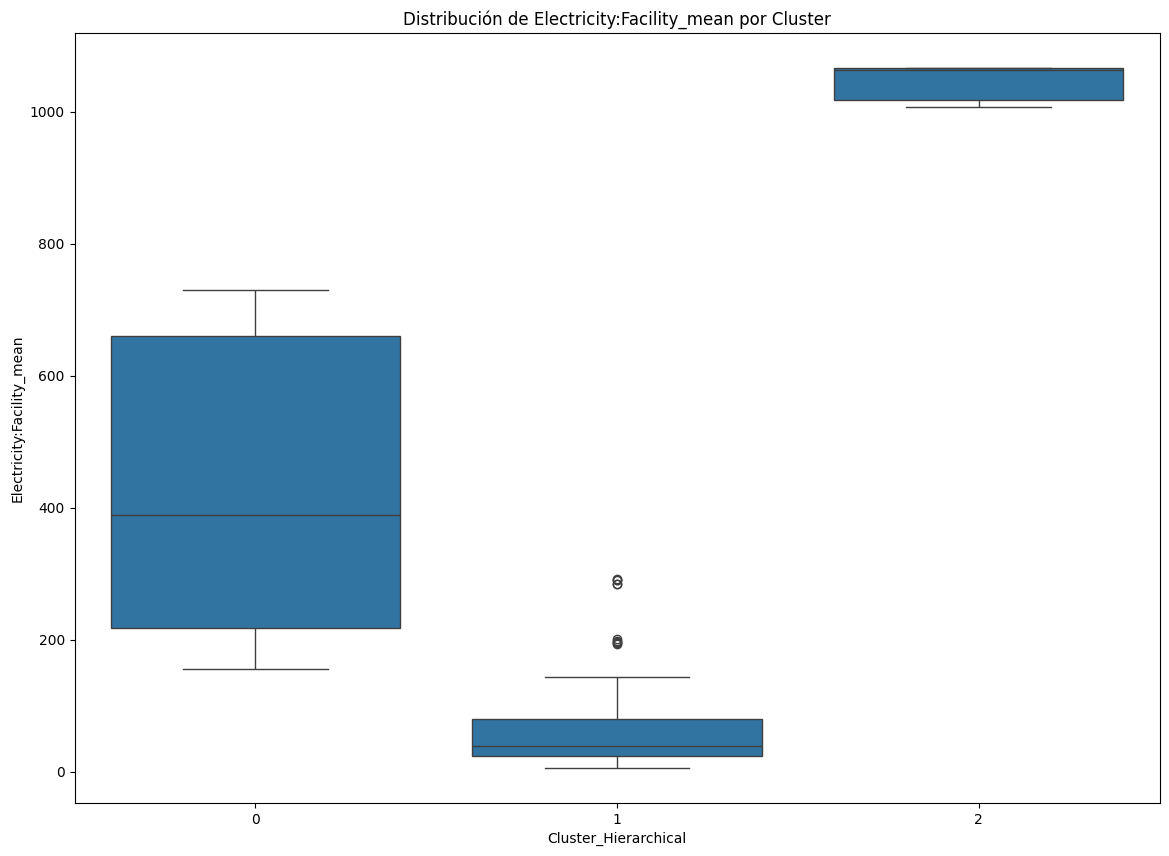

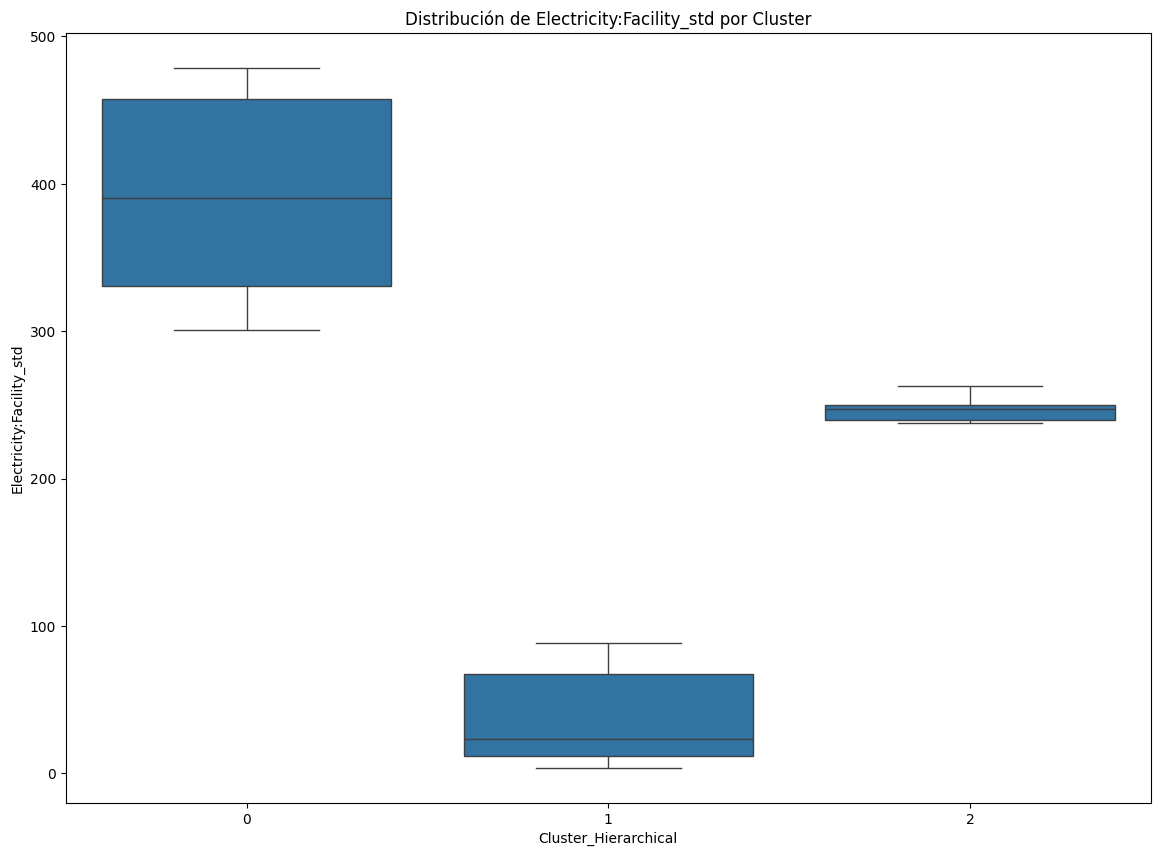

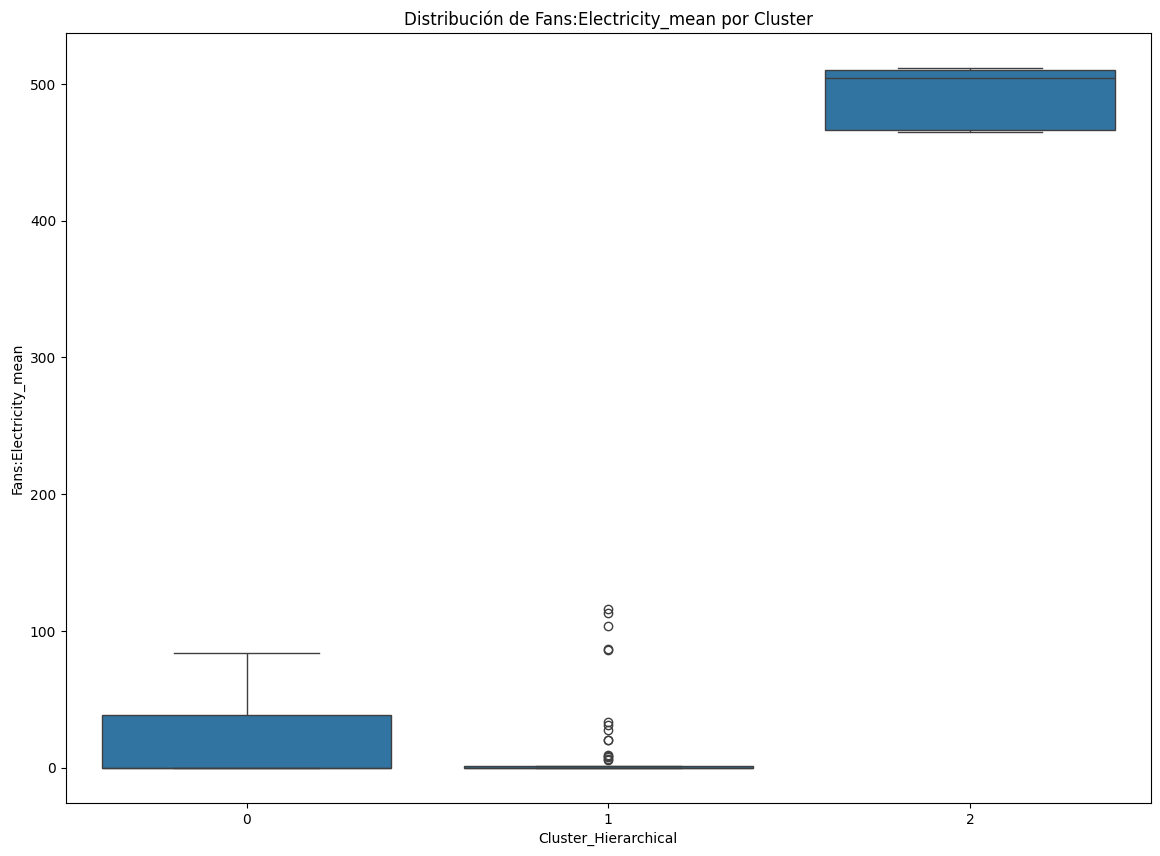

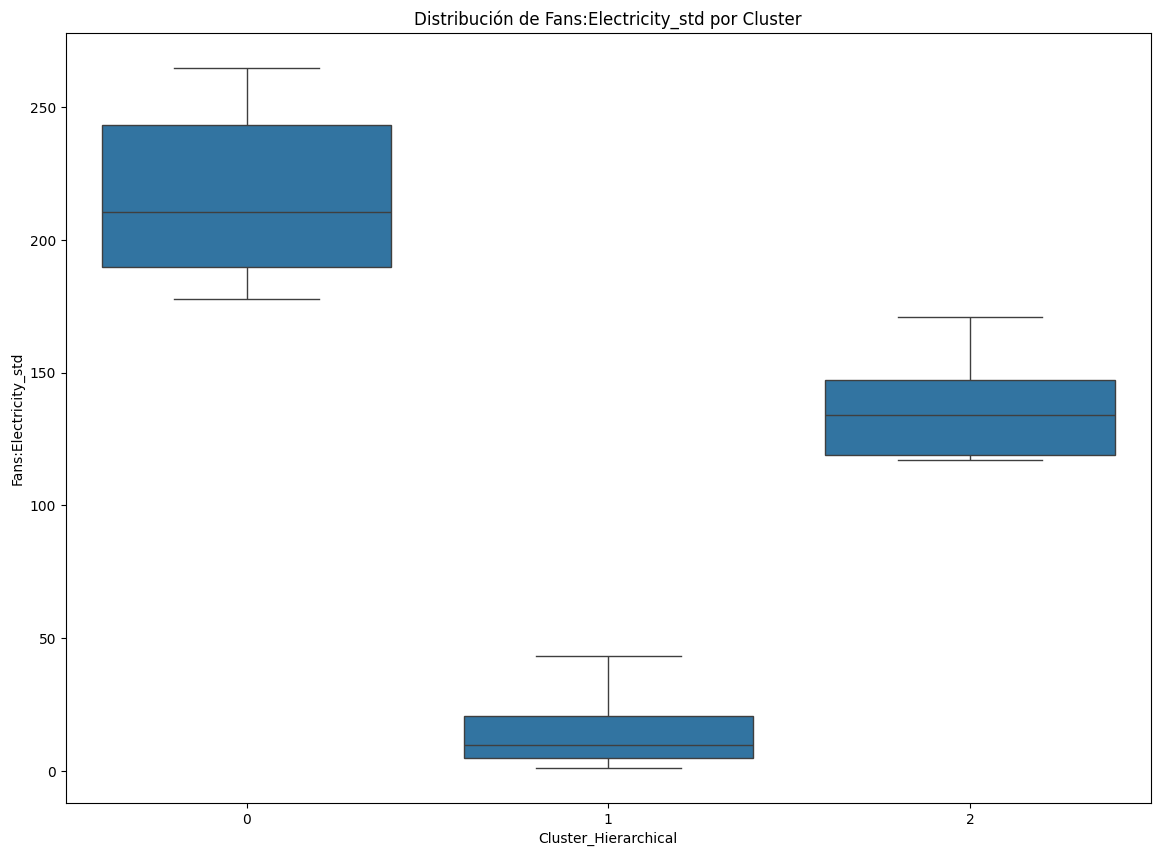

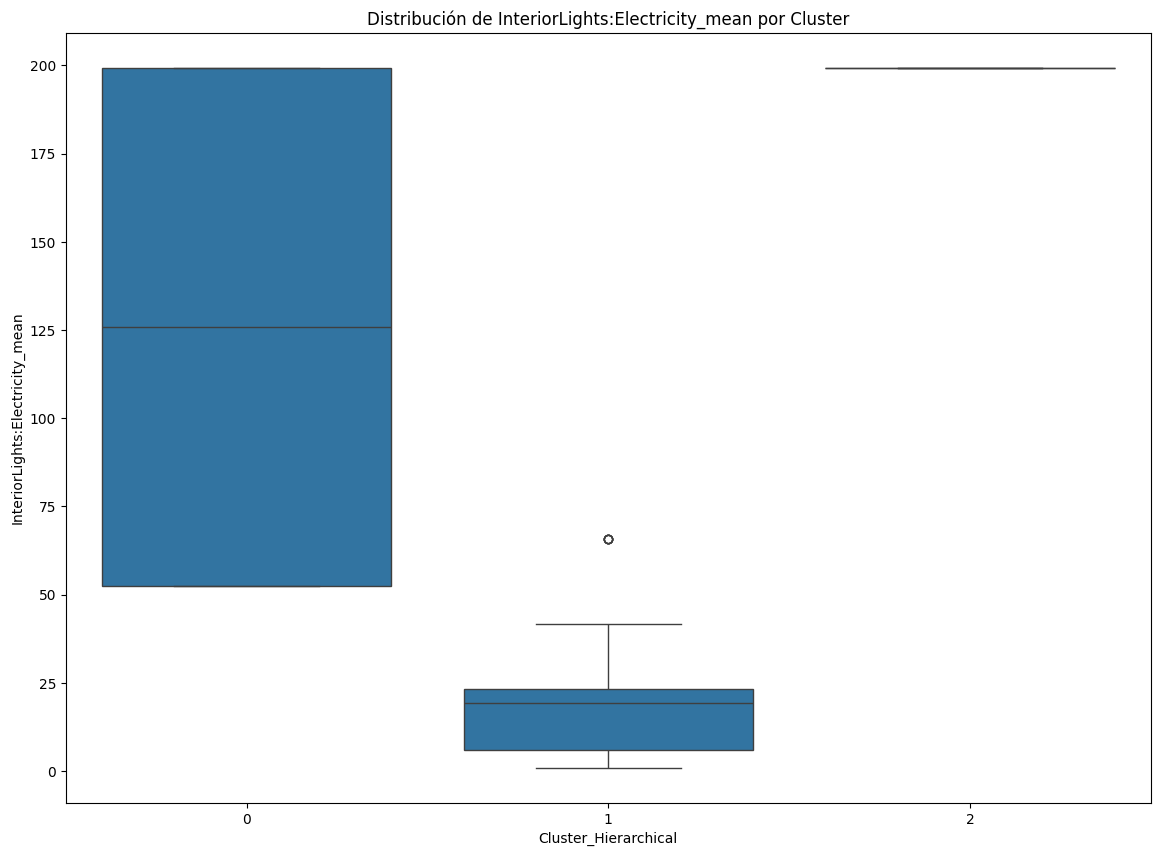

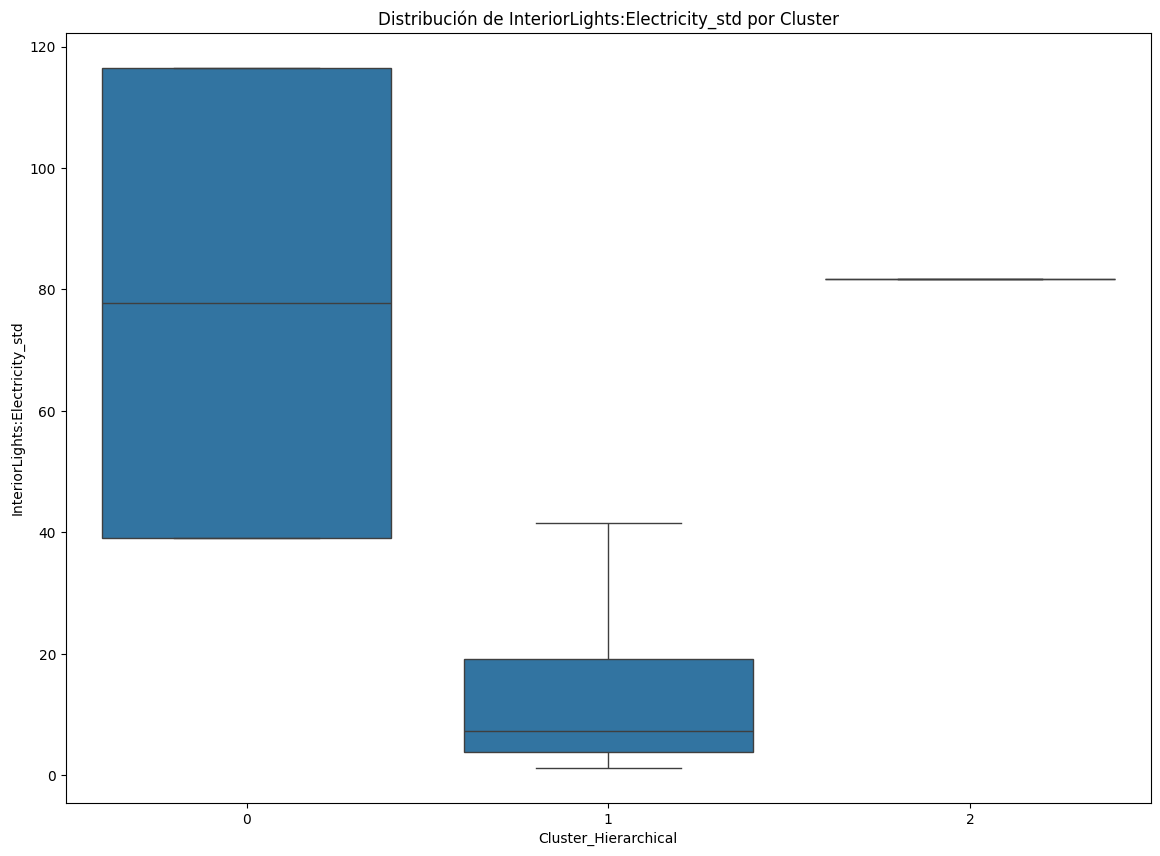

In [75]:
data_scaled_df = data_clustered.rename(columns={
    'var1_mean': 'Electricity:Facility_mean',
    'var1_std_dev': 'Electricity:Facility_std',
    'var2_mean': 'Fans:Electricity_mean',
    'var2_std_dev': 'Fans:Electricity_std',
    'var3_mean': 'InteriorLights:Electricity_mean',
    'var3_std_dev': 'InteriorLights:Electricity_std'
})

# Lista de las nuevas columnas
features_df = data_scaled_df[['Electricity:Facility_mean', 'Electricity:Facility_std', 
                           'Fans:Electricity_mean', 'Fans:Electricity_std', 
                           'InteriorLights:Electricity_mean', 'InteriorLights:Electricity_std']]

# Plotear los boxplots
for var in features_df.columns:
    plt.figure(figsize=(14, 10))
    sns.boxplot(data=data_scaled_df, x='Cluster_Hierarchical', y=var)
    plt.title(f'Distribución de {var} por Cluster')
    plt.show()

## Gaussian Mixture

In [16]:
from sklearn.mixture import GaussianMixture

Text(0.5, 0, 'Number Of Component')

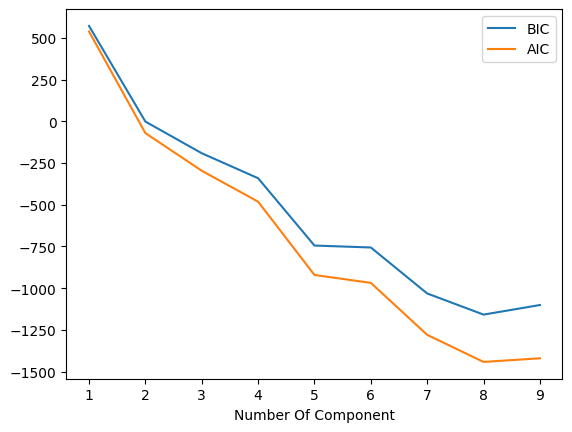

In [17]:
#Prepare
n_conponent = np.arange(1,10)

#Create GGM Model
models = [GaussianMixture(n_components = n,
                          random_state=42).fit(X) for n in n_conponent]
#Plot
plt.plot(n_conponent,
         [m.bic(X) for m in models],
         label = 'BIC')
plt.plot(n_conponent,
         [m.aic(X) for m in models],
         label = 'AIC')
plt.legend()
plt.xlabel("Number Of Component")

In [35]:
# create GM Models
model = GaussianMixture(n_components=5,
                        random_state=42).fit(X)
cluster = pd.Series(model.predict(X))
data_clustered['cluster_GMM'] = cluster
data_clustered

,type_building,var1_mean,var1_std_dev,var2_mean,var2_std_dev,cluster_GMM
0,RefBldgFullServiceRestaurantNew2004,0.000000,6.226848,19.4245,7.265027,0
1,RefBldgFullServiceRestaurantNew2004,0.001580,6.596764,19.4245,7.265027,0
2,RefBldgFullServiceRestaurantNew2004,0.002568,7.146033,19.4245,7.265027,0
3,RefBldgFullServiceRestaurantNew2004,0.000000,4.688730,19.4245,7.265027,0
4,RefBldgFullServiceRestaurantNew2004,0.000000,4.797245,19.4245,7.265027,0
...,...,...,...,...,...,...
75,RefBldgWarehouseNew2004,0.000000,3.543234,1.0116,3.418924,0
76,RefBldgWarehouseNew2004,0.000000,3.778460,1.0116,3.418924,0
77,RefBldgWarehouseNew2004,0.000000,3.968506,1.0116,3.418924,0
78,RefBldgWarehouseNew2004,0.000000,2.526466,1.0116,3.418924,0


In [38]:
# Calcular el silhouette score para evaluar la calidad de los clusters
silhouette_hierarchical = silhouette_score(X, cluster)
silhouette_hierarchical

0.7327960567617673

In [39]:
# Calcular el índice de Davies-Bouldin
davies_bouldin_hierarchical= davies_bouldin_score(X, cluster)
davies_bouldin_hierarchical

0.3696518450132545

In [40]:
data_clustered.cluster_GMM.value_counts()

cluster_GMM
0    55
4    10
2     5
1     5
3     5
Name: count, dtype: int64

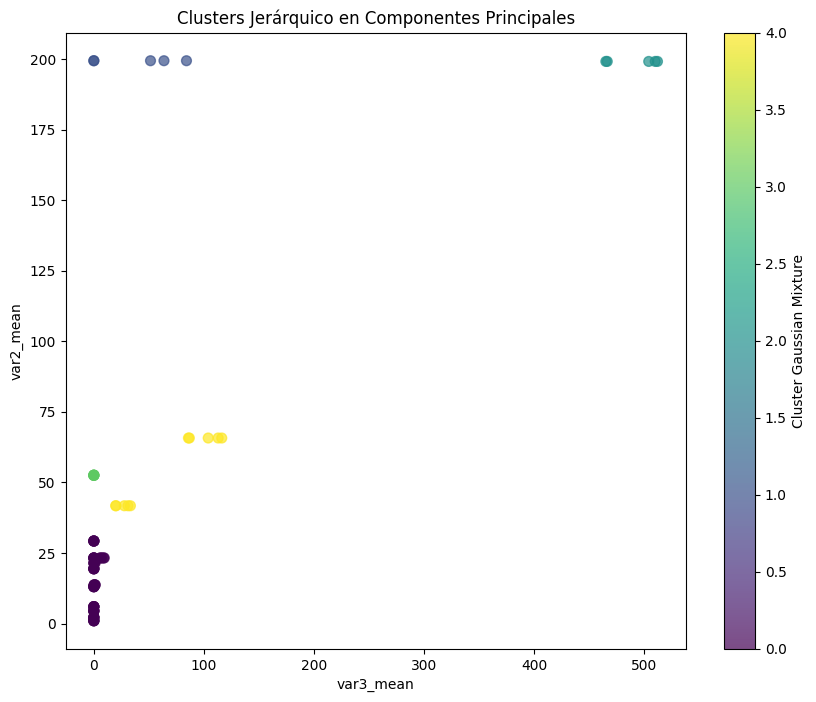

In [41]:
# Visualización de los clusters obtenidos por Clustering Jerárquico
plt.figure(figsize=(10, 8))
plt.scatter(data_clustered["var1_mean"], data_clustered['var2_mean'], c=data_clustered['cluster_GMM'], cmap='viridis', s=50, alpha=0.7)
plt.title('Clusters Jerárquico en Componentes Principales')
plt.xlabel('var3_mean')
plt.ylabel('var2_mean')
plt.colorbar(label='Cluster Gaussian Mixture')
plt.show()

In [42]:
# Create crosstab: ct
ct = pd.crosstab(data_clustered['type_building'] ,data_clustered['cluster_GMM'] )
# Display ct
ct

cluster_GMM,0,1,2,3,4
type_building,,,,,
RefBldgFullServiceRestaurantNew2004,5,0,0,0,0
RefBldgHospitalNew2004,0,0,5,0,0
RefBldgLargeHotelNew2004,0,0,0,0,5
RefBldgLargeOfficeNew2004,0,5,0,0,0
RefBldgMediumOfficeNew2004,5,0,0,0,0
RefBldgMidriseApartmentNew2004,5,0,0,0,0
RefBldgOutPatientNew2004,0,0,0,0,5
RefBldgPrimarySchoolNew2004,5,0,0,0,0
RefBldgQuickServiceRestaurantNew2004,5,0,0,0,0


In [45]:
data_clustered_df = data_clustered.rename(columns={
    'var1_mean': 'Cooling:Electricity_mean',
    'var1_std_dev': 'Cooling:Electricit_std',
    'var2_mean': 'InteriorEquipment:Electricity_mean',
    'var2_std_dev': 'InteriorEquipment:Electricity_std'
})
data_clustered_df.head()

,type_building,Cooling:Electricity_mean,Cooling:Electricit_std,InteriorEquipment:Electricity_mean,InteriorEquipment:Electricity_std,cluster_GMM
0,RefBldgFullServiceRestaurantNew2004,0.000000,6.226848,19.4245,7.265027,0
1,RefBldgFullServiceRestaurantNew2004,0.001580,6.596764,19.4245,7.265027,0
2,RefBldgFullServiceRestaurantNew2004,0.002568,7.146033,19.4245,7.265027,0
3,RefBldgFullServiceRestaurantNew2004,0.000000,4.688730,19.4245,7.265027,0
4,RefBldgFullServiceRestaurantNew2004,0.000000,4.797245,19.4245,7.265027,0


In [46]:
data_clustered_df.to_csv("../data/interim/clustering_all_characteristics.csv",index=False)